In [1]:
import numpy as np
np.random.seed(17) # fix NumPY random number generator seed

import networkx as nx
import matplotlib.pyplot as plt

import sampling

In [2]:
# initialize graph:
dimensions=[3,3,2]
nodes = sampling.init_square_grid_nodes(dimensions=dimensions)
edges = sampling.init_square_grid_internal_edges(nodes=nodes)
edges = sampling.add_square_grid_periodic_boundary_edges(
    dimensions=dimensions,
    nodes=nodes,
    edges=edges
)
G = sampling.Graph(nodes=nodes, edges=edges)

n = len(G.nodes())

# no external field
B = np.zeros(n)
G.set_external_field(B)

# ferromagnetic edges:
J = {e:1.0 for e in G.edges()}
G.set_couplings(J)

print("There are",n,"nodes in the graph.")
N = 2**n
print("number of possible states: ", float(N))

There are 18 nodes in the graph.
number of possible states:  262144.0


In [3]:
# Set temperature:

# The critical temperature if J_ij == 1 (TODO: verify this...)
# T_c = 2/np.log(1+np.sqrt(2))
# print("Critical temperature T_c:",T_c)


T = 3.0 # set Temperature T
print("System temperature T:",T)

k_B = 1.0 # set Boltzmann constant
beta = 1/(k_B*T)

System temperature T: 3.0


sample 0 ...


sample 100 ...
sample 200 ...
sample 300 ...
sample 400 ...


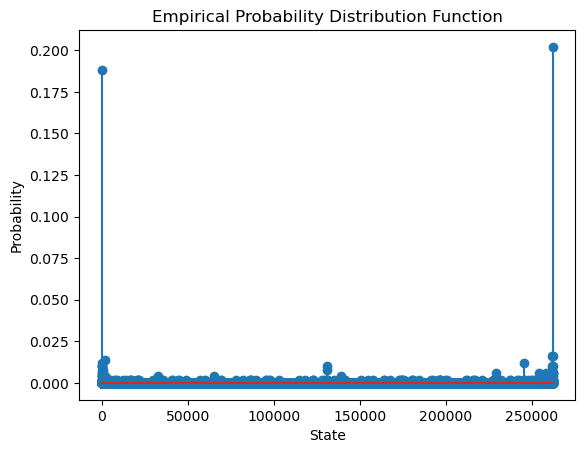

Note: if you used the same system parameters and lattice dimensions as in 02_brute_force_probability_distribution_calculation.ipynb, then this plot should look very similar.


In [4]:
# Monte Carlo Markov Chain (MCMC) with Metropolis Hastings (M-H) proposals.

num_samples = int(500)
num_steps = 500 # TODO: determine when the MCMC has mixed and stop!

# store samples as a dictionary with 
# counts of the number of times each state has appeared.
# samples = {} # necessary if N is very large.

empirical_pdf = np.zeros(N)

sample_energy_by_step = np.zeros((num_samples, num_steps))


for s in range(num_samples):

    # generate spin config to start the MCMC with
    
    ############################################################################
    ############################################################################
    ############################################################################
    ############################################################################
    # completely random spin config to start
    spin_config = sampling.generate_random_spin_config(n)
    ############################################################################
    ############################################################################
    ############################################################################
    ############################################################################
    
    
    
    G.set_spins(spin_config)

    # print progress
    if s % 100 == 0:
        print("sample",s,"...")

    step = 0 # init
    i = 0 # init
    E_current = G.energy() # record current energy

    while step < num_steps:
        # We run the MCMC for `num_steps` then output one sample.

        # proposed new state
        G.nodes[i]["spin"] *= -1 # flip sign. 
        E_proposed = G.energy()
        
        
        if E_proposed < E_current:
            # accept proposed state because it is lower energy.
            E_current = E_proposed
        else:
            threshold = np.exp(-beta*(E_proposed - E_current))
            u = np.random.random()
            if u < threshold:
                # accept proposed state even though it is higher energy
                E_current = E_proposed
            else:
                # do NOT accept proposed state
                # keep E_current set as is (no update)
                G.nodes[i]["spin"] *= -1 # revert to keep the "current" state
        
        # run through nodes in typewriter order.
        i += 1 
        i = i % n 
        
        sample_energy_by_step[s, step] = E_current + 0.5*(np.random.random() - 0.5) # add random dither so plots look more interesting.
        step += 1 # increment

    # log final spin configuration
    state_index = sampling.convert_spin_config_to_state_index(G.get_spins())
    empirical_pdf[state_index] += 1


empirical_pdf *= (1/num_samples) #normalize

plt.stem(empirical_pdf)
plt.xlabel("State")
plt.ylabel("Probability")
plt.title("Empirical Probability Distribution Function")
plt.show()


print("Note: if you used the same system parameters and lattice dimensions as in 02_brute_force_probability_distribution_calculation.ipynb, then this plot should look very similar.")






In [5]:
# a visual inspection of the heat map of count of energy bin per step

# num_bins = 50
# energy_range = (-50,20)

# energy_histogram_by_step = np.zeros((num_bins, num_steps))

# for step in range(num_steps):
#     h = np.histogram(sample_energy_by_step[:,step], bins=num_bins, range=(-50,20))
#     h_counts = h[0]
#     energy_histogram_by_step[:,step] = h_counts

# plt.imshow(energy_histogram_by_step)
# plt.show()

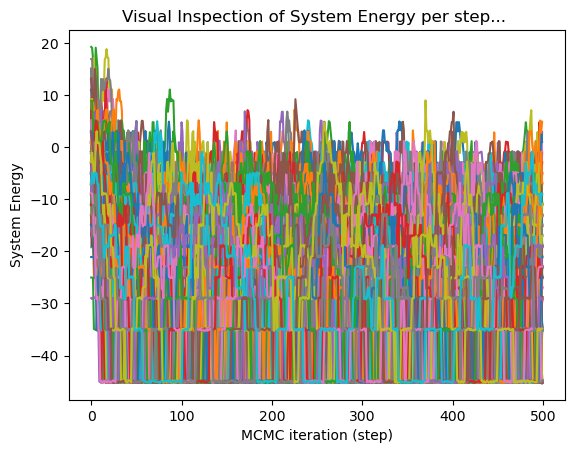

In [6]:
for s in range(num_samples):
    plt.plot(sample_energy_by_step[s,:])
plt.xlabel("MCMC iteration (step)")
plt.ylabel("System Energy")
plt.title("Visual Inspection of System Energy per step... ")
plt.show()

In [7]:
# write out the histogram as a .csv file for the 04_verification_of_samples.ipynb

output = np.zeros((N,n + 1))

# first column is the counts from the histogram
output[:,0] = np.round(empirical_pdf * num_samples) #blow this back up into counts rather than normalized probabilities.  TODO: make sure we aren't m

for state_index in range(N):
    spin_config = sampling.convert_state_index_to_spin_config(n, state_index)
    output[state_index,1:] = spin_config

np.savetxt("benchmark_performer_submissions/mcmc_samples.csv", output, delimiter=",", fmt='%d')


# TODO: ensure output format is consistent
